In [99]:
from scipy.integrate import odeint
from scipy.signal import argrelextrema
import numpy as np
from numpy import sin, cos, sqrt
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from itertools import count

_omega=1.4005
_ma=1335.535
_f=6250
_K=10000
_Kt=1000
_a=0.5
_lamda = 656.3616
_lamdat = 151.4388
_Ia = 6779.315
_L = 1690

def get_args(K=_K, Kt=_Kt, a=_a, pro_id=1, const_K=True):
    if pro_id==1:
        return (K, -1, a, _omega, _ma, _f, _lamda, -1, -1, -1, const_K)
    elif pro_id==2:
        return (K, -1, a, 2.2143, 1165.992, 4890, 167.8395, -1, -1, -1, const_K)
    elif pro_id==3:
        return (K, Kt, a, 1.7152, 1028.876, 3640, 683.4558, 654.3383, 7001.914, 1690, const_K)
    elif pro_id==4:
        return (K, Kt, a, 1.9806, 1091.099, 1760, 1655.909, 528.5018, 7142.493, 2140, const_K)


def Model1(y, t, K=_K, Kt=_Kt, a=_a, omega=_omega, ma=_ma, f=_f, lamda=_lamda, lamdat=_lamda, Ia=_Ia, L=_L, const_K=True, rho=1025, g=9.8, mf=4866, mb=2433, k=80000, kt=250000, l=0.5, ht=0.8, hc=3, r=1):
    y1, y2, z1, z2 = y

    dy1 = y2
    dz1 = z2

    Ff=0
    if np.abs(y1)<=ht:
        Ff=-1/3*rho*g*np.pi*r*r*y1
    elif ht+hc>=np.abs(y1)>ht:
        Ff=rho*g*((np.pi*(r*r)*ht)/3-np.pi*r*r*(y1+ht))
    elif np.abs(y1)>=ht+hc:
        Ff=rho*g*(1/3*np.pi*r*r*ht+np.pi*r*r*hc)
    
    if not const_K:
        K=K*np.power(np.abs(z2-y2),a)
    
    dy2 = (f*cos(omega*t)-(mf)*g+k*(z1-y1-ht-l)+K*(z2-y2)-lamda*y2+Ff)/(ma+mf)
    dz2 = (-mb*g-k*(z1-y1-ht-l)-K*(z2-y2))/mb

    return [dy1, dy2, dz1, dz2]

y0 = [-2.80001093, 0, -1.79805351, 0]
y0t = [-2.80001093, 0, -1.79805351, 0, 0, 0, 0, 0]

def Model2(y, t, K=_K, Kt=_Kt, a=_a, omega=_omega, ma=_ma, f=_f, lamda=_lamda, lamdat=_lamda, Ia=_Ia, L=_L, const_K=True, rho=1025, g=9.8, mf=4866, mb=2433, k=80000, kt=250000, l=0.5, ht=0.8, hc=3, r=1):
    xcf = (3/2*hc**2-1/3*ht**2)/(3*hc+ht)
    mc = (3*hc)/(3*hc+ht)*mf
    mt = (ht)/(3*hc+ht)*mf
    If = 1/12*mc*(3*r**2+hc**2)+mc*(1/2*hc-xcf)**2+3/20*mt*(r**2+ht**2/4)+mt*(1/3*ht+xcf)**2
        
    y1, y2, z1, z2, N1, N2, M1, M2 = y
    
    Ff=0
    if np.abs(y1)<=ht:
        Ff=-1/3*rho*g*np.pi*r*r*y1
    elif ht+hc>=np.abs(y1)>ht:
        Ff=rho*g*((np.pi*(r*r)*ht)/3-np.pi*r*r*(y1+ht))
    elif np.abs(y1)>=ht+hc:
        Ff=rho*g*(1/3*np.pi*r*r*ht+np.pi*r*r*hc)
    
    if not const_K:
        K=K*np.power(np.abs(z2-y2),a)
    
    dy1 = y2
    dz1 = z2
    
    dy2 = (f*cos(omega*t)-(mf)*g+k*(z1-y1-ht-l)+K*(z2-y2)-lamda*y2+Ff)/(ma+mf)
    dz2 = (-mb*g-k*(z1-y1-ht-l)-K*(z2-y2))/mb
    
    dN1 = N2
    dM1 = M2
    
    # dN2 = (Kt*(M2-N2)+kt*(M1-N1))/(mb*(xcf**2+(z1-y1-ht)**2)-2*xcf*(z1-y1-ht)*sin(N1))
    
    dN2 = 0
    dM2 = 0
    dN2 = (Kt*(M2-N2)+kt*(M1-N1))/(mb*((xcf)**2))
    dM2 = (L*cos(omega*t)-Kt*(M2-N2)-kt*(M1-N1)-lamdat*M2)/(If+Ia)
    
    
    return [dy1, dy2, dz1, dz2, dN1, dN2, dM1, dM2]
    

def get_Es(xf,xb,vf,vb,K=_K,a=_a,const_K=True):
    dv = np.abs(vf-vb)
    dv = (dv[:-1]+dv[1:])/2
    dx = xf-xb
    ddx = np.abs(dx[1:]-dx[:-1])
    if not const_K:
        K = K*np.power(dv,a)
    Es = K*dv*ddx
    return Es

# def get_W(Model, y0, t, args=get_args()):
#     tend = t[-1]
#     nstep = len(t)
#     Tstep = int(nstep/tend*2*np.pi/args[3])
#     sol = odeint(Model, y0, t,args=args)
#     xf = sol[:,0]
#     xb = sol[:,2]
#     vf = sol[:,1]
#     vb = sol[:,3]
#     Es = get_Es(xf,xb,vf,vb,args[0])
    
#     mean_step = Tstep*10
#     if(nstep<mean_step):
#         return np.sum(Es)/t[-1]
#     else:
#         return np.sum(Es[-Tstep*10:-1])/(t[-1]-t[-Tstep*10])

def solve(Model,y0,t0=100,args=get_args(),log=False,valid=[1,1]):
    bg = 0
    ed = t0
    delta_t = ed-bg
    t_step = 10
    nstep = delta_t*t_step
    t = np.linspace(bg,ed,nstep)
    Tstep = int(t_step*2*np.pi/args[3])
    
    nT = 10
    
    while True:
        sol = odeint(Model, y0, t, args=args)
        Wsum = 0
        flag = True
            
        if sol.shape[1]>=4 and valid[0]:
            xf = sol[:,0]
            xb = sol[:,2]
            vf = sol[:,1]
            vb = sol[:,3]
            Es = get_Es(xf,xb,vf,vb,args[0],args[2],args[-1])
            
            # 法1
            # W1 = np.sum(Es[int(-3/2*nT*Tstep):int(-1/2*nT*Tstep)])/(t[int(-1/2*nT*Tstep)]-t[int(-3/2*nT*Tstep)])
            # W2 = np.sum(Es[int(-nT*Tstep):-1])/(t[-1]-t[int(-nT*Tstep)])
            
            # 法2
            Ws = np.cumsum(Es)/(t[1:]-t[0])
            W1 = Ws[int(-3/2*nT*Tstep)]
            W2 = Ws[int(-nT*Tstep)]
            
            if(np.abs(W1-W2)/W2<0.001):
                Wsum+=Ws[-1]
            else:
                flag=False
                
            if log:
                print(ed,W1,W2,Ws[-1])
            
        if flag and sol.shape[1]>=8 and valid[1]:
            xf = sol[:,4]
            xb = sol[:,6]
            vf = sol[:,5]
            vb = sol[:,7]
            Es = get_Es(xf,xb,vf,vb,args[1],args[2],args[-1])
            
            # 法1
            # W1 = np.sum(Es[int(-3/2*nT*Tstep):int(-1/2*nT*Tstep)])/(t[int(-1/2*nT*Tstep)]-t[int(-3/2*nT*Tstep)])
            # W2 = np.sum(Es[int(-nT*Tstep):-1])/(t[-1]-t[int(-nT*Tstep)])
            
            # 法2
            Ws = np.cumsum(Es)/(t[1:]-t[0])
            W1 = Ws[int(-3/2*nT*Tstep)]
            W2 = Ws[int(-nT*Tstep)]
            
            # print(ed,W1,W2)
            if(np.abs(W1-W2)/W2<0.001):
                Wsum+=Ws[-1]
            else:
                flag=False
        
            if log:
                print(ed, W1, W2, Ws[-1])
        
        if flag:
            return Wsum
        
        bg = ed
        ed*=2
        
        delta_t = ed-bg
        nstep = delta_t*50
        Tstep = int(nstep/delta_t*2*np.pi/args[3])
        t = np.linspace(bg,ed,nstep)
        y0 = sol[-1]    

def plotModel(Model, y0, tend, args=get_args(), plot_Ws=True,file_name='data',kind=None):
    div = 20
    nstep = int(tend*div)
    t = np.linspace(0, tend, nstep)
    Tstep = int(nstep/tend*2*np.pi/args[3])
    sol = odeint(Model, y0, t,args=args)
    fig, ax = plt.subplots(3,2, figsize=(20, 15))
    
    xf = sol[:,0]
    xb = sol[:,2]
    vf = sol[:,1]
    vb = sol[:,3]
    # arg = argrelextrema(xf, np.greater)
    # print(np.diff(t[arg]),np.diff(arg))
    
    # print(sol[-1,0],sol[-1,2])
    
    i=0
    ax[0,i].plot(t, sol[:, 0], 'b', label='y1:x_f')
    ax[0,i].plot(t, sol[:, 2], 'g', label='z1:x_b')
    
    # ax[0].plot(t, sol[:, 0]-sol[:, 2], label='y1-z1:x_f-x_b')
    
    ax[1,i].plot(t, sol[:, 1], 'b', label='y2:v_f')
    ax[1,i].plot(t, sol[:, 3], 'g', label='z2:v_b')
    
    # ax[1].plot(t, sol[:, 1]-sol[:, 3], label='y2-z2:v_f-v_b')
    
    if file_name:
        arg = np.arange(0,Tstep*41,step=div/5,dtype=int)
        data = np.array([xf[arg],vf[arg],xb[arg],vb[arg]]).T
        pd.DataFrame(data,columns=['xf','vf','xb','vb'],index=t[arg]).to_csv(f'{file_name}.csv')
    
    if plot_Ws:
        Es = get_Es(xf,xb,vf,vb,args[0],args[2],args[-1])
        
        ax[2,i].plot(t[1:], Es, label='E')
        
        # cal_t = int(50*Tstep)
        # print(cal_t,t[cal_t])
        # Ws = np.convolve(Es, np.ones(cal_t), 'valid')/(tend/nstep*cal_t)
        # ax[2].plot(t[cal_t:], Ws, label='Ws')
        
        Ws = np.cumsum(Es)/t[1:]
        ax[2,i].plot(t[1:], Ws, label='W')
        ax[2,i].axhline(y=Ws[-1], color='r', linestyle='-')
        
        
        print('W =',Ws[-1])
        
    
    if sol.shape[1]==8:
        xf = sol[:, 4]
        xb = sol[:, 6]
        vf = sol[:, 5]
        vb = sol[:, 7]
        # arg = argrelextrema(xf, np.greater)
        # print(np.diff(t[arg]),np.diff(arg))

        # print(sol[-1,0],sol[-1,2])

        i=1
        ax[0,i].plot(t, xf, 'b', label='y1:t_f')
        ax[0,i].plot(t, xb, 'g', label='z1:t_b')
        # ax[0].plot(t, sol[:, 0]-sol[:, 2], label='y1-z1:x_f-x_b')
        

        ax[1,i].plot(t, vf, 'b', label='y2:t_f')
        ax[1,i].plot(t, vb, 'g', label='z2:t_b')
        # ax[1].plot(t, sol[:, 1]-sol[:, 3], label='y2-z2:v_f-v_b')
        
        
        if file_name:
            arg = np.arange(0,Tstep*41,step=div/5,dtype=int)
            data = np.array([xf[arg],vf[arg],xb[arg],vb[arg]]).T
            pd.DataFrame(data,columns=['xf','vf','xb','vb'],index=t[arg]).to_csv(f'{file_name}t.csv')
        
        if plot_Ws:
            Es = get_Es(xf, xb, vf, vb, args[1], args[2], args[-1])

            ax[2,i].plot(t[1:], Es, label='Es')

            # cal_t = int(50*Tstep)
            # print(cal_t,t[cal_t])
            # Ws = np.convolve(Es, np.ones(cal_t), 'valid')/(tend/nstep*cal_t)
            # ax[2].plot(t[cal_t:], Ws, label='Ws')

            Ws = np.cumsum(Es)/t[1:]
            ax[2,i].plot(t[1:], Ws, label='Ws')

            ax[2,i].axhline(y=Ws[-1], color='r', linestyle='-')
            
            print('Wt =', Ws[-1])
    for a in ax.flatten():
        a.legend()
    plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


W = 12.528139499807567


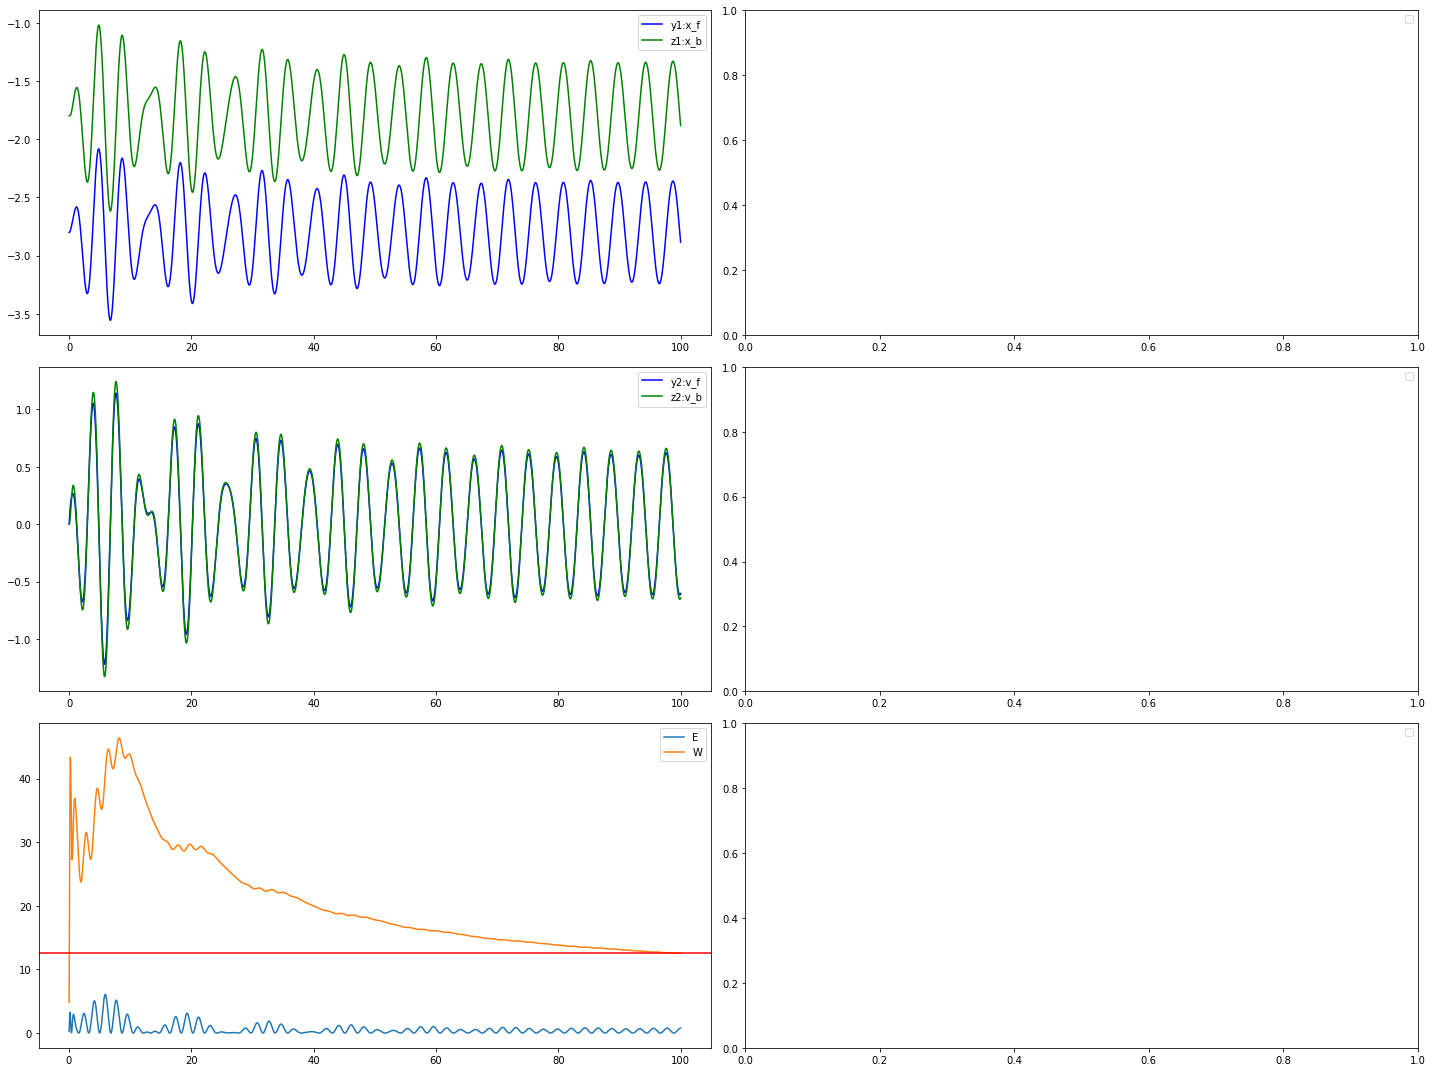

In [108]:
plotModel(Model1, y0, 100, args=get_args(pro_id=1), plot_Ws=True,file_name=None)
# 1.1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


W = 3.4633383030126232


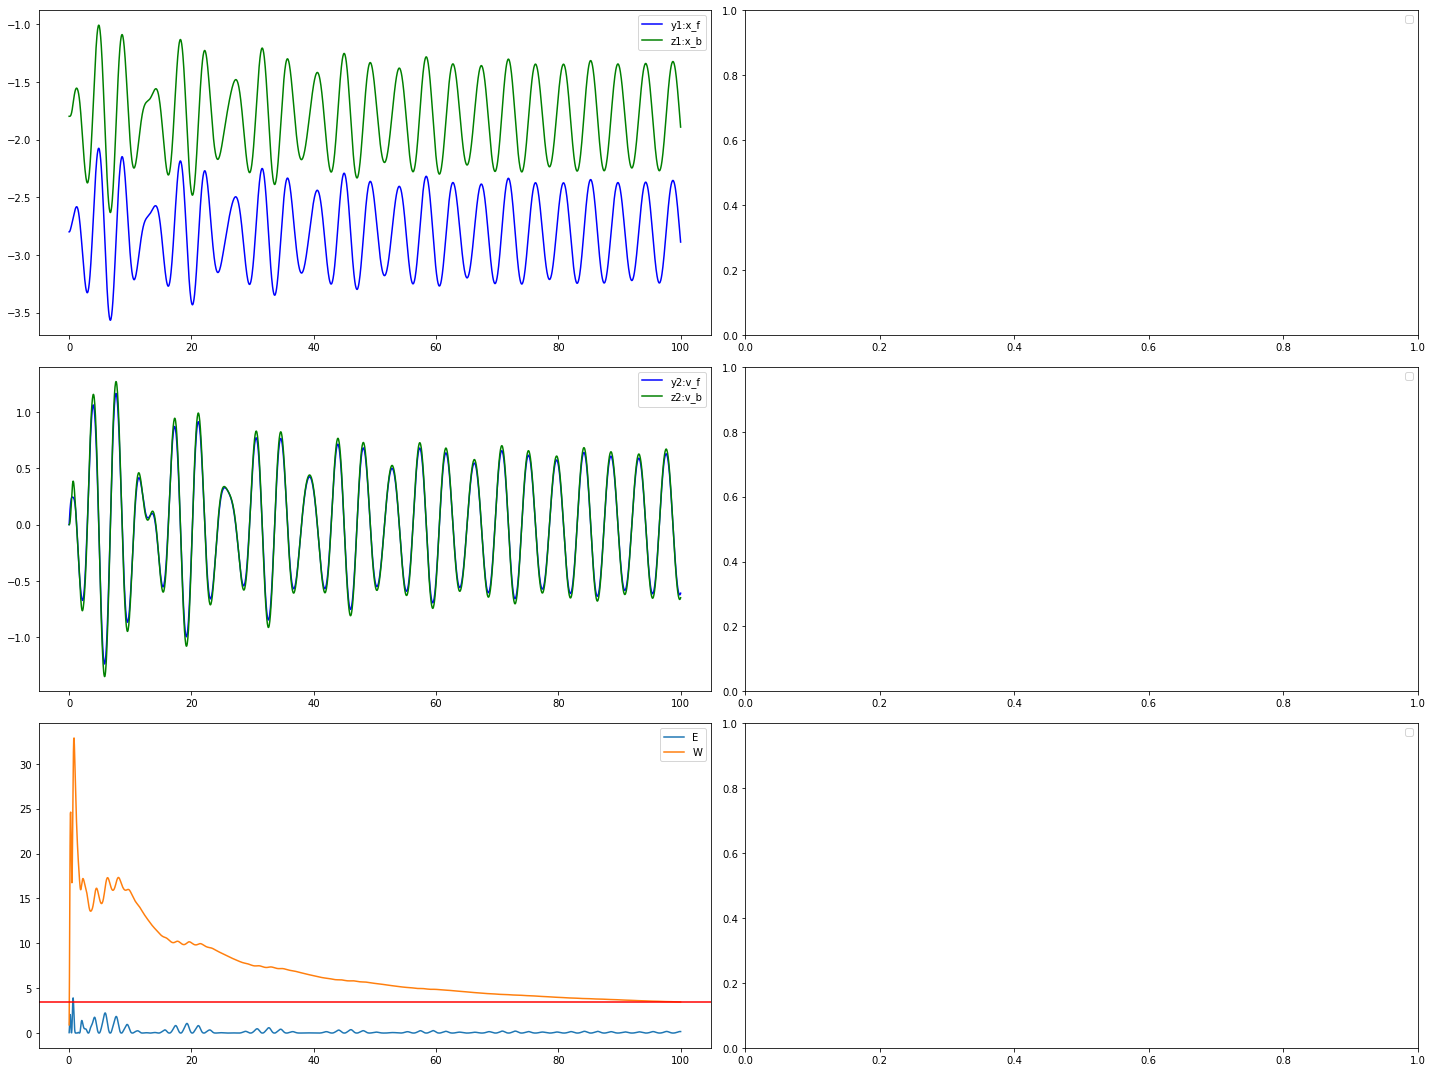

In [109]:
plotModel(Model1, y0, 100, args=get_args(pro_id=1,const_K=False), plot_Ws=True,file_name=None)
# 1.2

W = 49.65082029655787
Wt = 0.008852713807129988


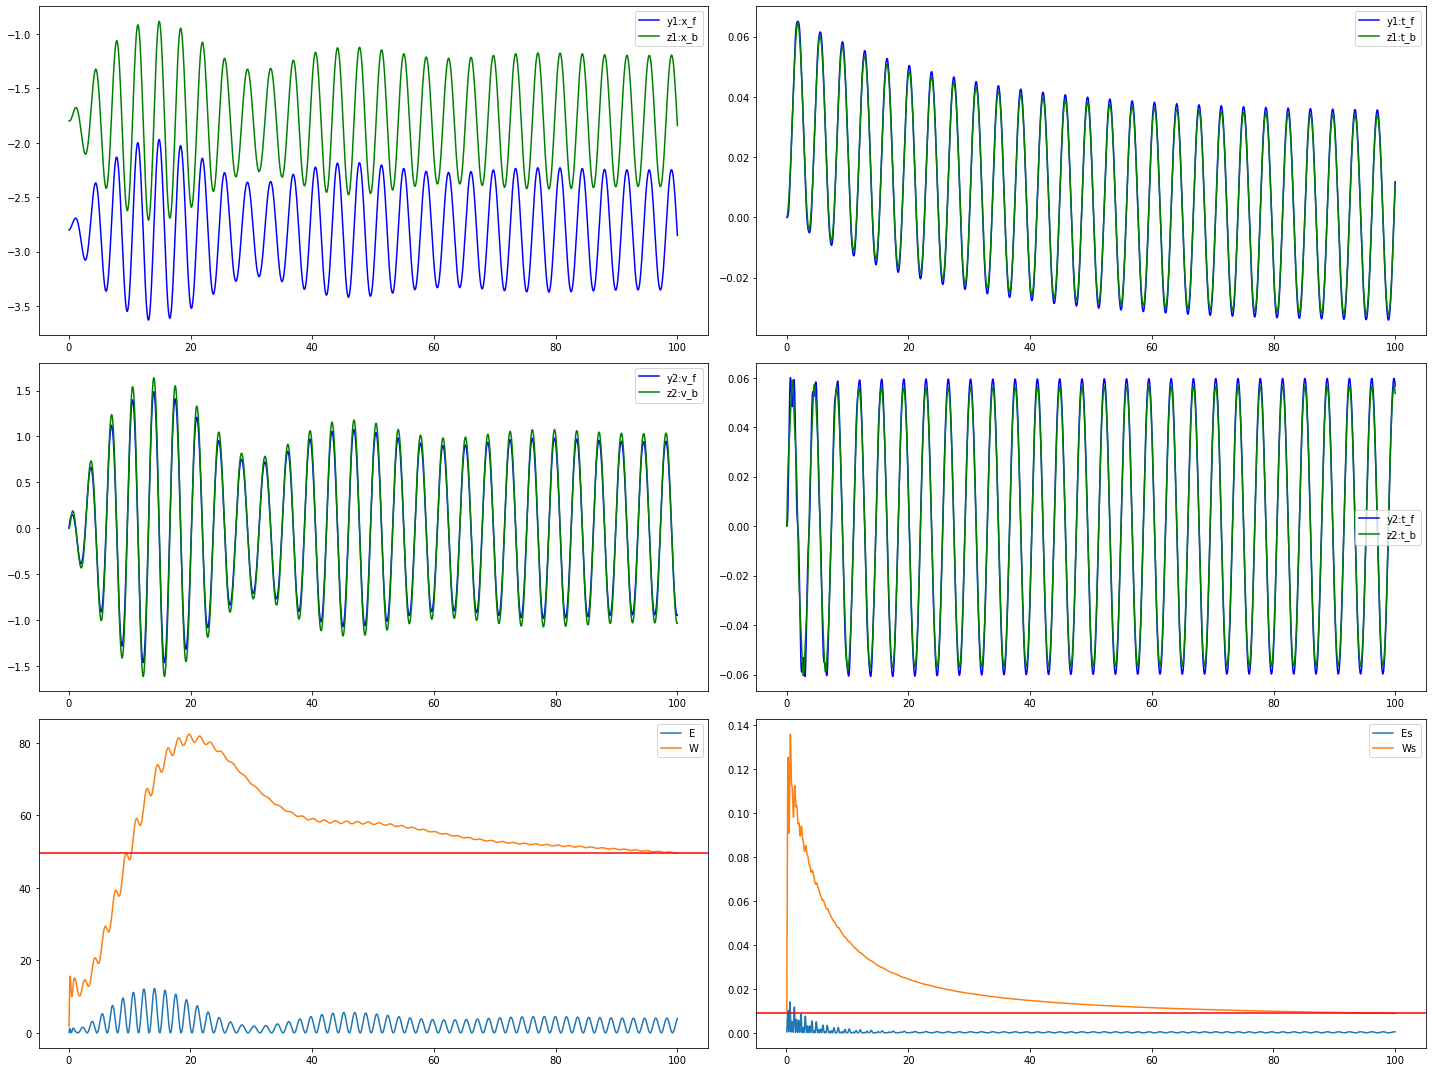

In [110]:
plotModel(Model2, y0t, 100, args=get_args(pro_id=3,const_K=True), plot_Ws=True,file_name=None)
# 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


W = 8.536746195570716


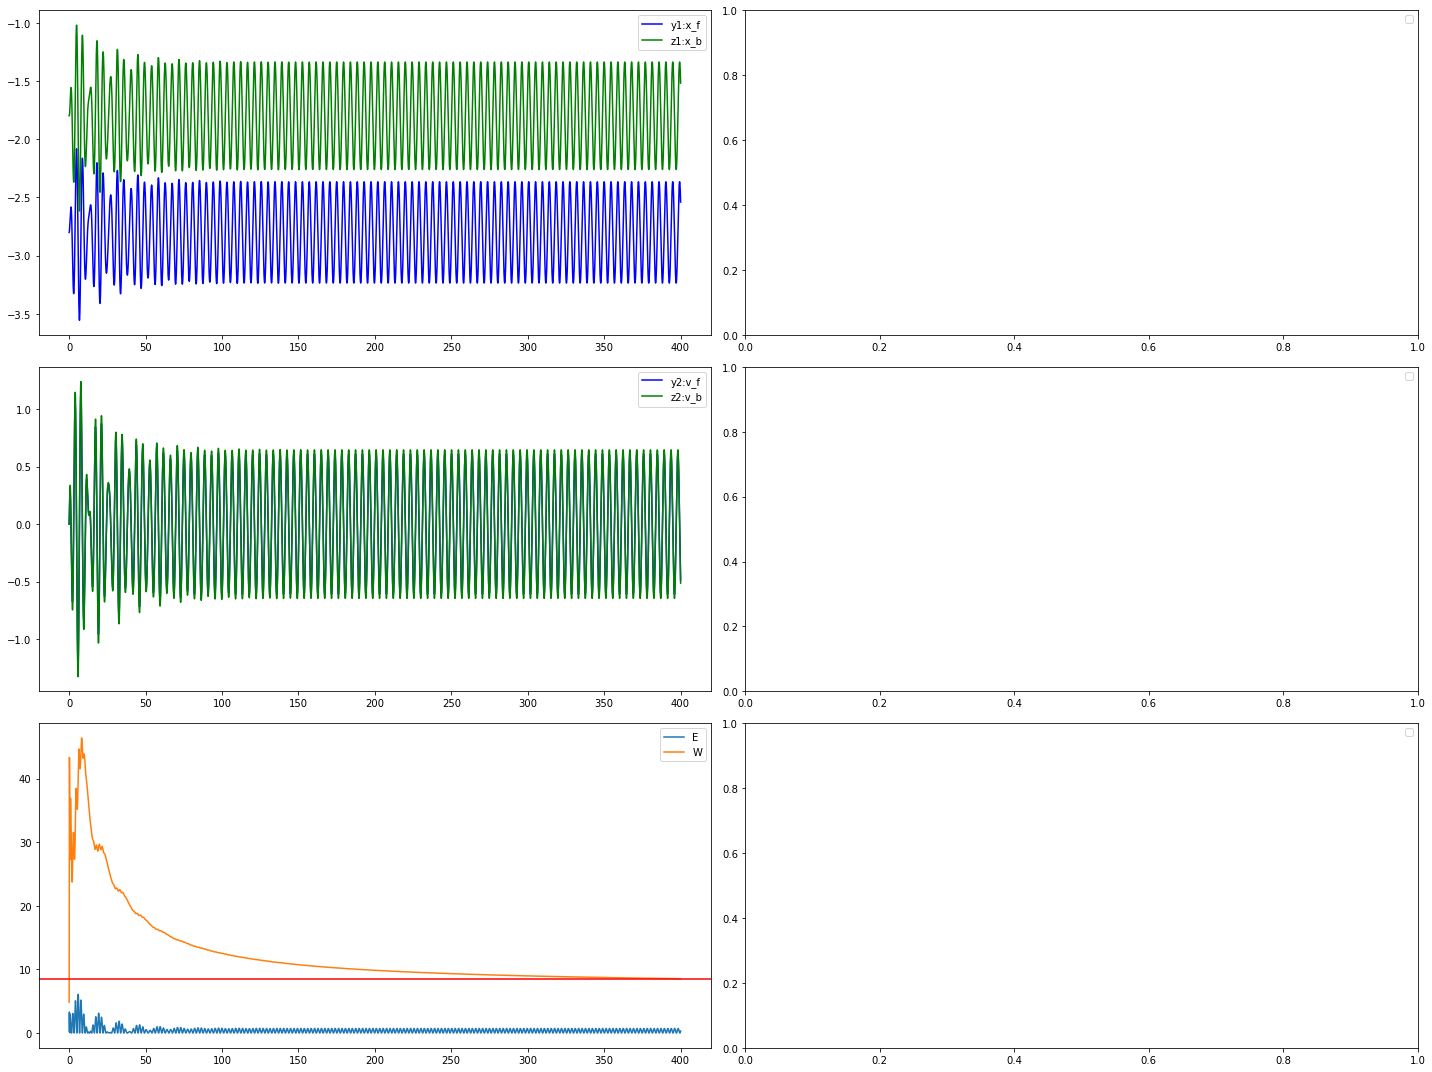

In [101]:
plotModel(Model1, y0, 400, args=get_args(pro_id=1), plot_Ws=True,file_name='1.1')

W = 1.8704778820950683


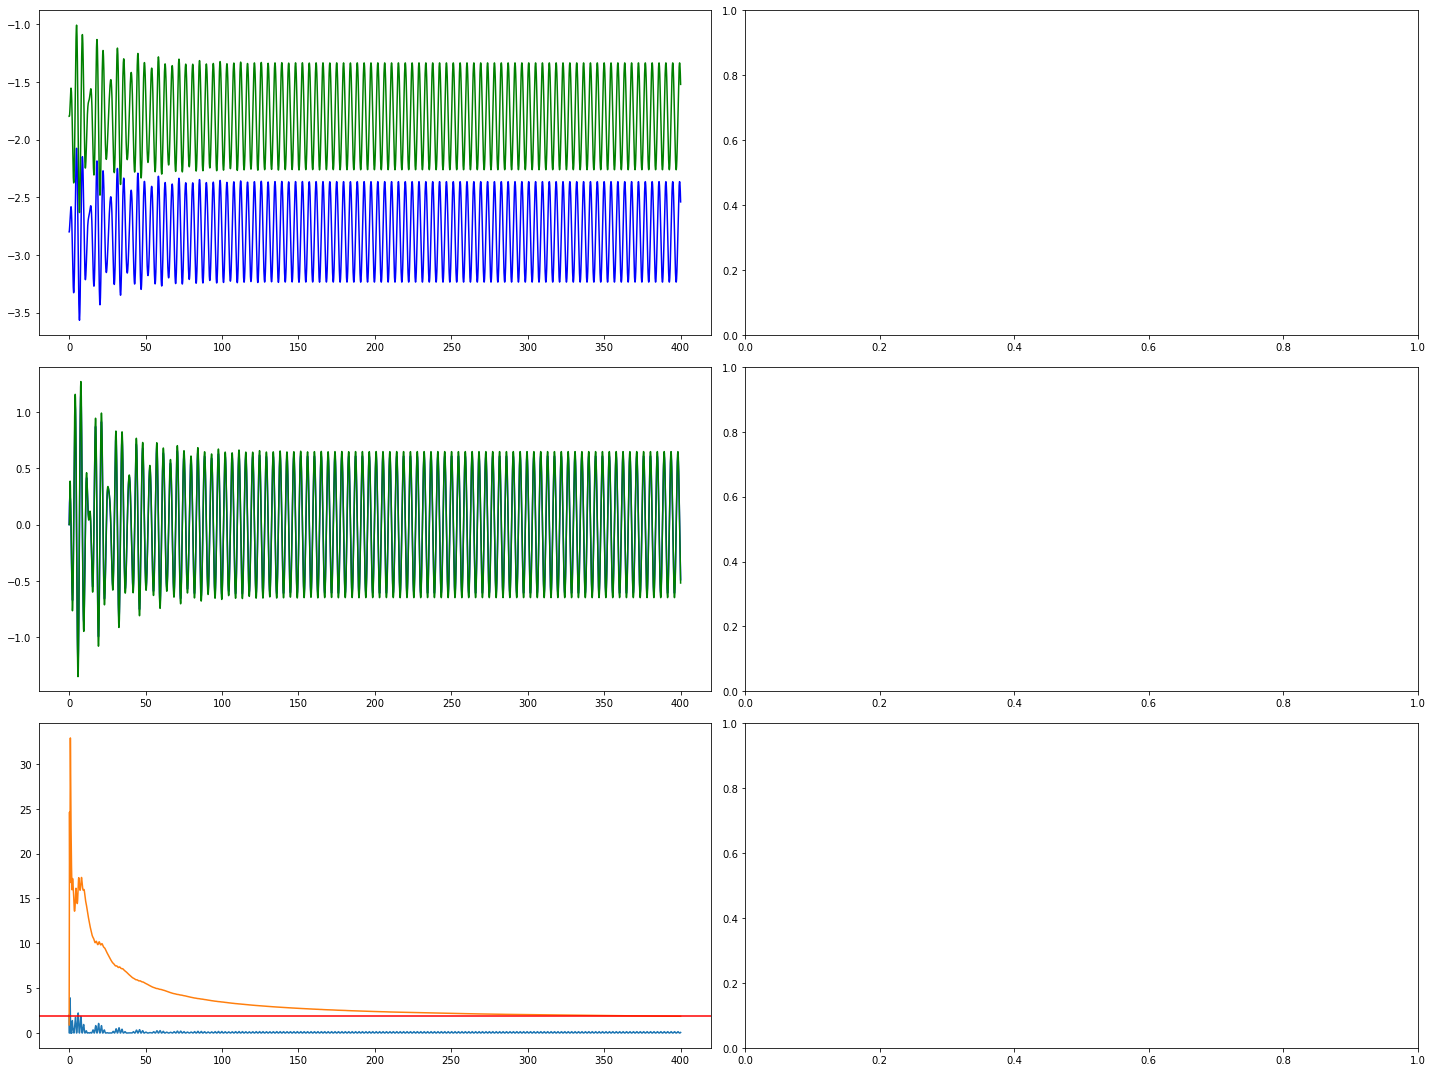

In [68]:
plotModel(Model1, y0, 400, args=get_args(pro_id=1,const_K=False), plot_Ws=True,file_name='1.2')

W = 43.74342389901025
Wt = 0.00591347432250699


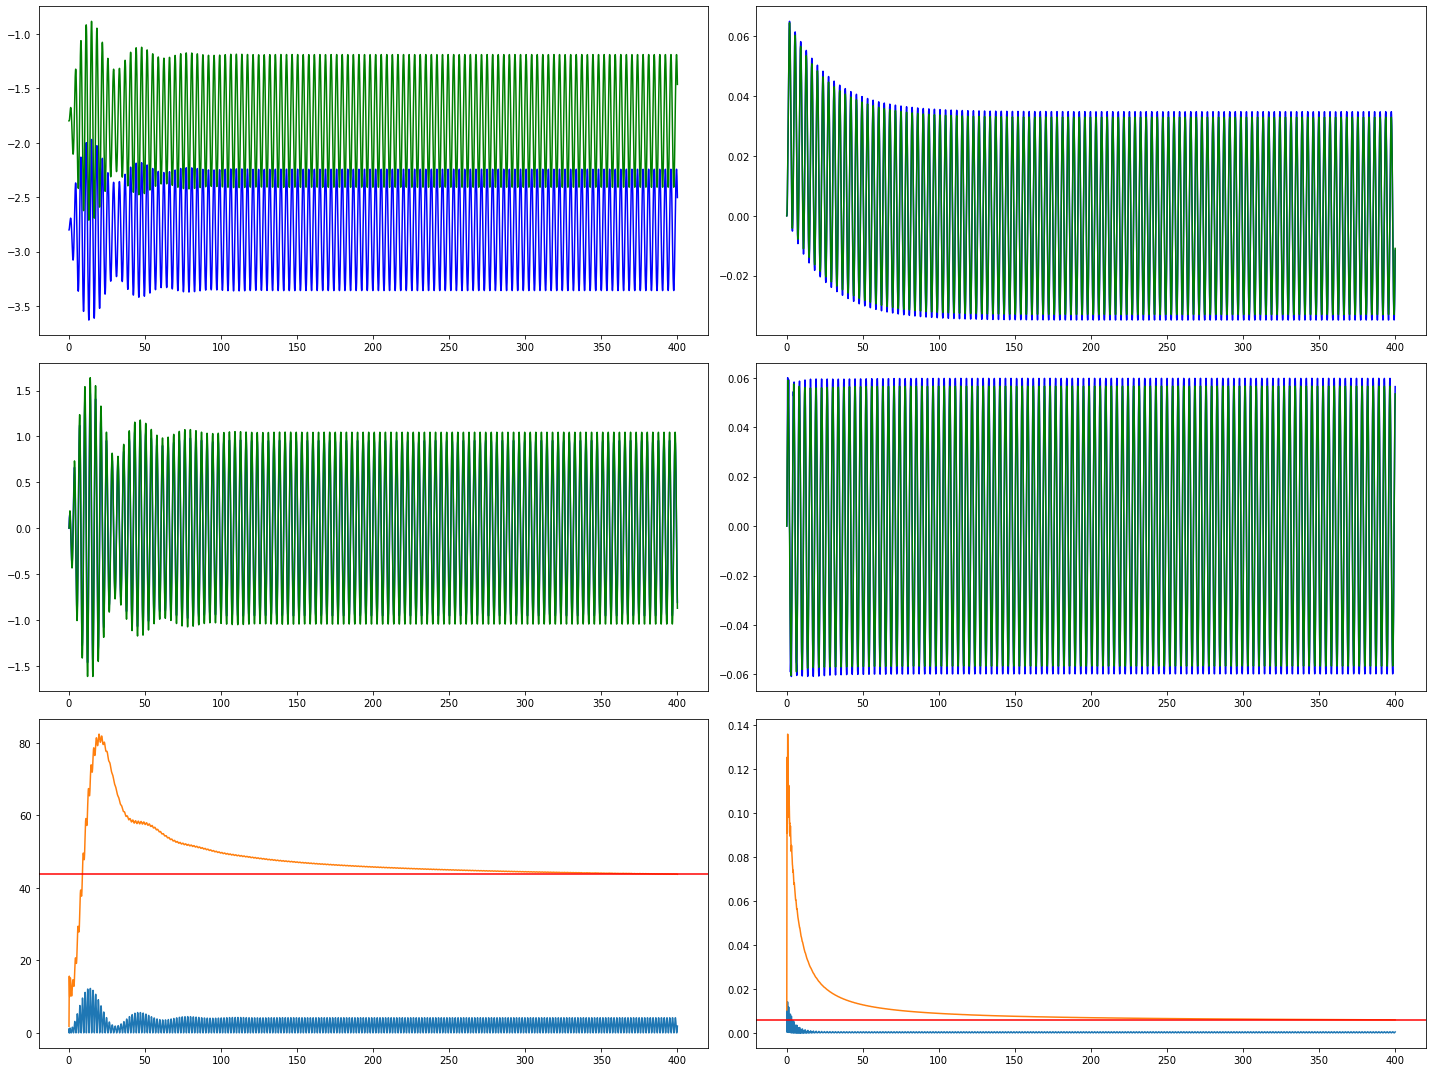

In [69]:
plotModel(Model2,y0t,400,get_args(Kt=1000,pro_id=3,const_K=True),file_name='3')

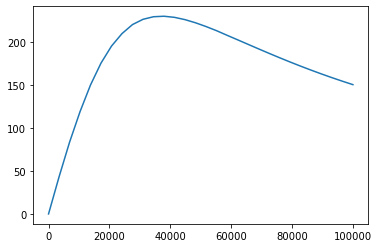

In [71]:
x_list = np.linspace(1, 100000, 30)
y_list = [solve(Model1,y0,args=get_args(K=K, pro_id=2, const_K=True)) for K in x_list]
plt.plot(x_list, y_list)

In [72]:
def maxinmun(func, a, b, log=False):
    # for _ in tqdm(count()):
    for _ in count():
        x = a+(b-a)/float(3)
        y = a+2*(b-a)/float(3)
        fx = func(x)
        fy = func(y)
        if fx < fy:
            a = x
        else:
            b = y

        if b-a < 0.1:
            break
        
        if log:
            tqdm.write('n = {}, a = {}, b = {}, fx = {}, fy = {}'.format(_,a,b,fx,fy))

    return a, func(a)


In [73]:
# 2(1)
func = lambda x: solve(Model1,y0,100,get_args(K=x,pro_id=2,const_K=True))
maxinmun(func, 1,100000,log=False)
# (37140.19107738316, 229.6618253272917)

(37132.222122885934, 229.66182670092942)

2(2)

400it [06:07,  1.09it/s]


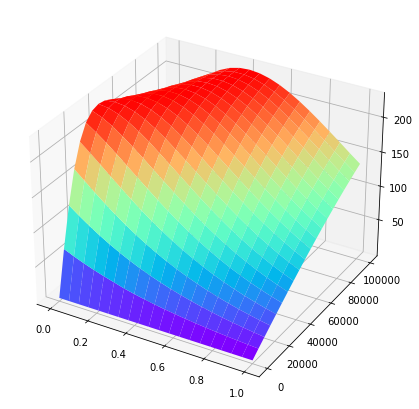

In [76]:
n_a = n_K = 20
a_list = np.linspace(0,1,n_a)
K_list = np.linspace(1,100000,n_K)
aa, KK = np.meshgrid(a_list, K_list)
# y = np.zeros(n_a*n_K)
yy = []
for a,K in tqdm(zip(aa.flatten(), KK.flatten())):
    
    if K>100000*a or True:
        yy.append(solve(Model1,y0,args=get_args(K=K,a=a,pro_id=2,const_K=False)))
    else:
        yy.append(0)
        
yy = np.array(yy).reshape(n_a,n_K)
fig = plt.figure(1, figsize=(24, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_top_view()

ax.plot_surface(aa, KK, yy, rstride=1, cstride=1, cmap='rainbow')
plt.show()


([-1.5104645534649912, 1.794860594150833, 2.0853976550152273],
 array([109944.36710918, 101601.93648783,  36143.02853801]),
 230.208614484654)

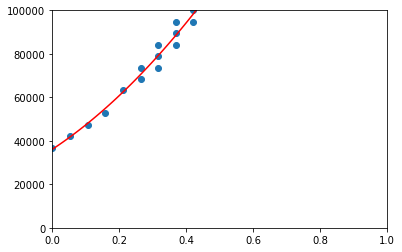

In [79]:
bound = 229.5
plt.scatter(aa[yy>bound].flatten(),KK[yy>bound].flatten())
res = np.polyfit(aa[yy>bound].flatten(),KK[yy>bound].flatten(),2)
a = np.linspace(0,1,100)
plt.plot(a, res[0]*a**2+res[1]*a+res[2], 'r')
plt.xlim(0,1)
plt.ylim(0, 100000)
res

from scipy import optimize
from math import pi

def r(x, y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)


def f(c, x, y):
    Ri = r(x, y, *c)
    return np.square(Ri - Ri.mean())

def least_squares_circle(x,y):
    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center, _ = optimize.leastsq(f, center_estimate, args=(x, y))
    xc, yc = center
    Ri       = r(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return xc, yc, R, residu

def plot_circle(xc, yc, R):
    theta_fit = np.linspace(-pi, pi, 180)
    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.plot(x_fit, y_fit*100000, 'b-')
    
xc,yc,R,_ = least_squares_circle(aa[yy>bound].flatten(),(KK[yy>bound]/100000).flatten())
# plot_circle(xc,yc,R)
[xc,yc,R],res,yy.max()


100it [01:31,  1.09it/s]


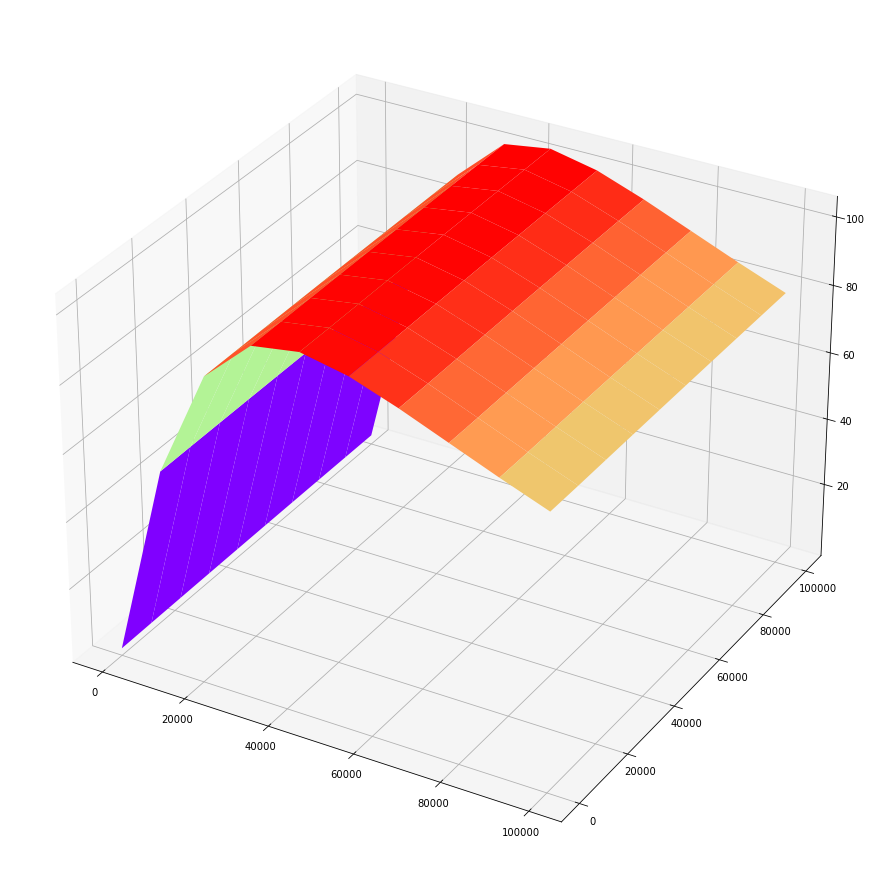

In [113]:
# 4
n_K = n_Kt = 10
K_list = np.linspace(1,100000,n_K)
Kt_list = np.linspace(1,100000,n_Kt)
KK, KKt = np.meshgrid(K_list, Kt_list)
# y = np.zeros(n_a*n_K)
yy = []
for K,Kt in tqdm(zip(KK.flatten(), KKt.flatten())):
    yy.append(solve(Model2,y0t,args=get_args(K=K,Kt=Kt,pro_id=4,const_K=True)))
yy = np.array(yy).reshape(n_K,n_Kt)
fig = plt.figure(1, figsize=(24, 16))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_top_view()

ax.plot_surface(KK, KKt, yy, cmap='rainbow')
# ax.set_zlim(100, yy.max())
plt.show()

[44445. 44445. 44445. 44445. 44445. 44445. 44445. 44445. 44445. 44445.] [1.0000e+00 1.1112e+04 2.2223e+04 3.3334e+04 4.4445e+04 5.5556e+04
 6.6667e+04 7.7778e+04 8.8889e+04 1.0000e+05] 103.76670560016474


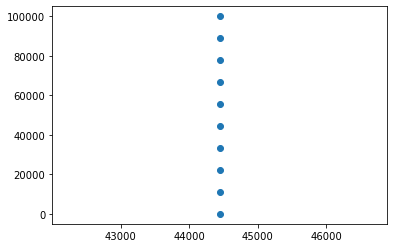

In [ ]:
arg = yy>102
K = KK[arg]
Kt = KKt[arg]
plt.scatter(K,Kt)
print(K,Kt,yy.max())
# K = 44445, Kt = ?, max=103.76670560016474

20 1
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   | 2.27909E+02 | 2.27909E+02 | 1.15890E+02 | 1.55194E+01 | 6.13491E+01 
 1 |   40   | 2.30047E+02 | 2.30047E+02 | 1.84088E+02 | 1.40717E+02 | 3.02769E+01 
 2 |   60   | 2.30047E+02 | 2.30047E+02 | 2.23315E+02 | 2.05470E+02 | 8.95939E+00 
 3 |   80   | 2.30047E+02 | 2.30047E+02 | 2.29116E+02 | 2.27909E+02 | 9.11806E-01 
 4 |  100   | 2.30047E+02 | 2.30047E+02 | 2.29994E+02 | 2.29912E+02 | 4.81509E-02 
 5 |  120   | 2.30047E+02 | 2.30047E+02 | 2.30031E+02 | 2.29973E+02 | 2.25459E-02 


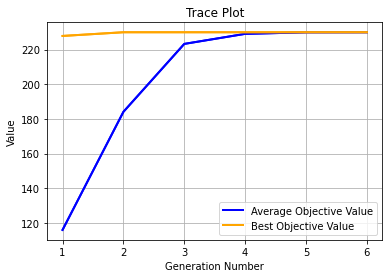

Simple GA result: [8.55600000e+04 3.47982665e-01]


In [ ]:
import numpy as np
import geatpy as ea
class MyProblem(ea.Problem): # Inherited from Problem class.
    def __init__(self): # M is the number of objects.
        name = 'Model1' # Problem's name.
        maxormins = [-1]
        M = 1
        Dim = 2
        varTypes = [1,0]
        lb = [1,0]
        ub = [100000,1]
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub)
    def aimFunc(self, pop): # Write the aim function here, pop is an object of Population class.
        Vars = pop.Phen # Get the decision variables
        ret = np.array([[solve(Model1,y0,100,get_args(K=K,a=a,pro_id=2,const_K=False))] for K,a in Vars])
        pop.ObjV = ret
        
problem = MyProblem()
NIND=20
Encoding='BG'
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)
population = ea.Population(Encoding, Field, NIND)
print(population.sizes,problem.M)
myAlgorithm = ea.soea_SEGA_templet(problem, population)
myAlgorithm.MAXGEN = 6
myAlgorithm.logTras = 1
myAlgorithm.verbose = True
myAlgorithm.drawing = 1
[BestIndi, population] = myAlgorithm.run()
BestIndi.save()
print('Simple GA result:',BestIndi.Phen[0])
